<div class='alert-block' style='background-color: #007bff; color: #ffffff;'>
    <br>
    <h1 align="center"><b>Part 1：</b> Data Analysis and Baseline model</h1>
    <h5 align="center">Wenbo Sui</h5>
    <br>
</div>

# 1.Dataset Characterization

In [11]:
import pandas as pd
import numpy as np
import wfdb
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [28]:
# Load metadata
path = '../data/raw/physionet.org/files/ptb-xl/1.0.3/'
df = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))
scp_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
diag_scp_df = scp_df[scp_df.diagnostic == 1]

# Aggregate diagnostic superclass
def agg_diag(dic):
    classes = {diag_scp_df.loc[k].diagnostic_class 
               for k in dic.keys() 
               if k in diag_scp_df.index}
    return [c for c in classes if c == c]

df['diagnostic_superclass'] = df.scp_codes.apply(agg_diag)
print(df['diagnostic_superclass'])

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 21799, dtype: object


## Sample and Subject Size

In [80]:
n_records = len(df)
n_patients = df['patient_id'].nunique()

print(f"Records: {n_records}")
print(f"Patients num: {n_patients}")

# check balance
recs_per_patient = df.groupby('patient_id').size()
print(f"Average records per patient: {recs_per_patient.mean():.2f}")

Records: 21799
Patients num: 18869
Average records per patient: 1.16


While the average record count (1.16) is close to 1, the existence of thousands of additional records indicates a long-tail effect. Therefore, a Cumulative Distribution Plot is employed for further. analysis

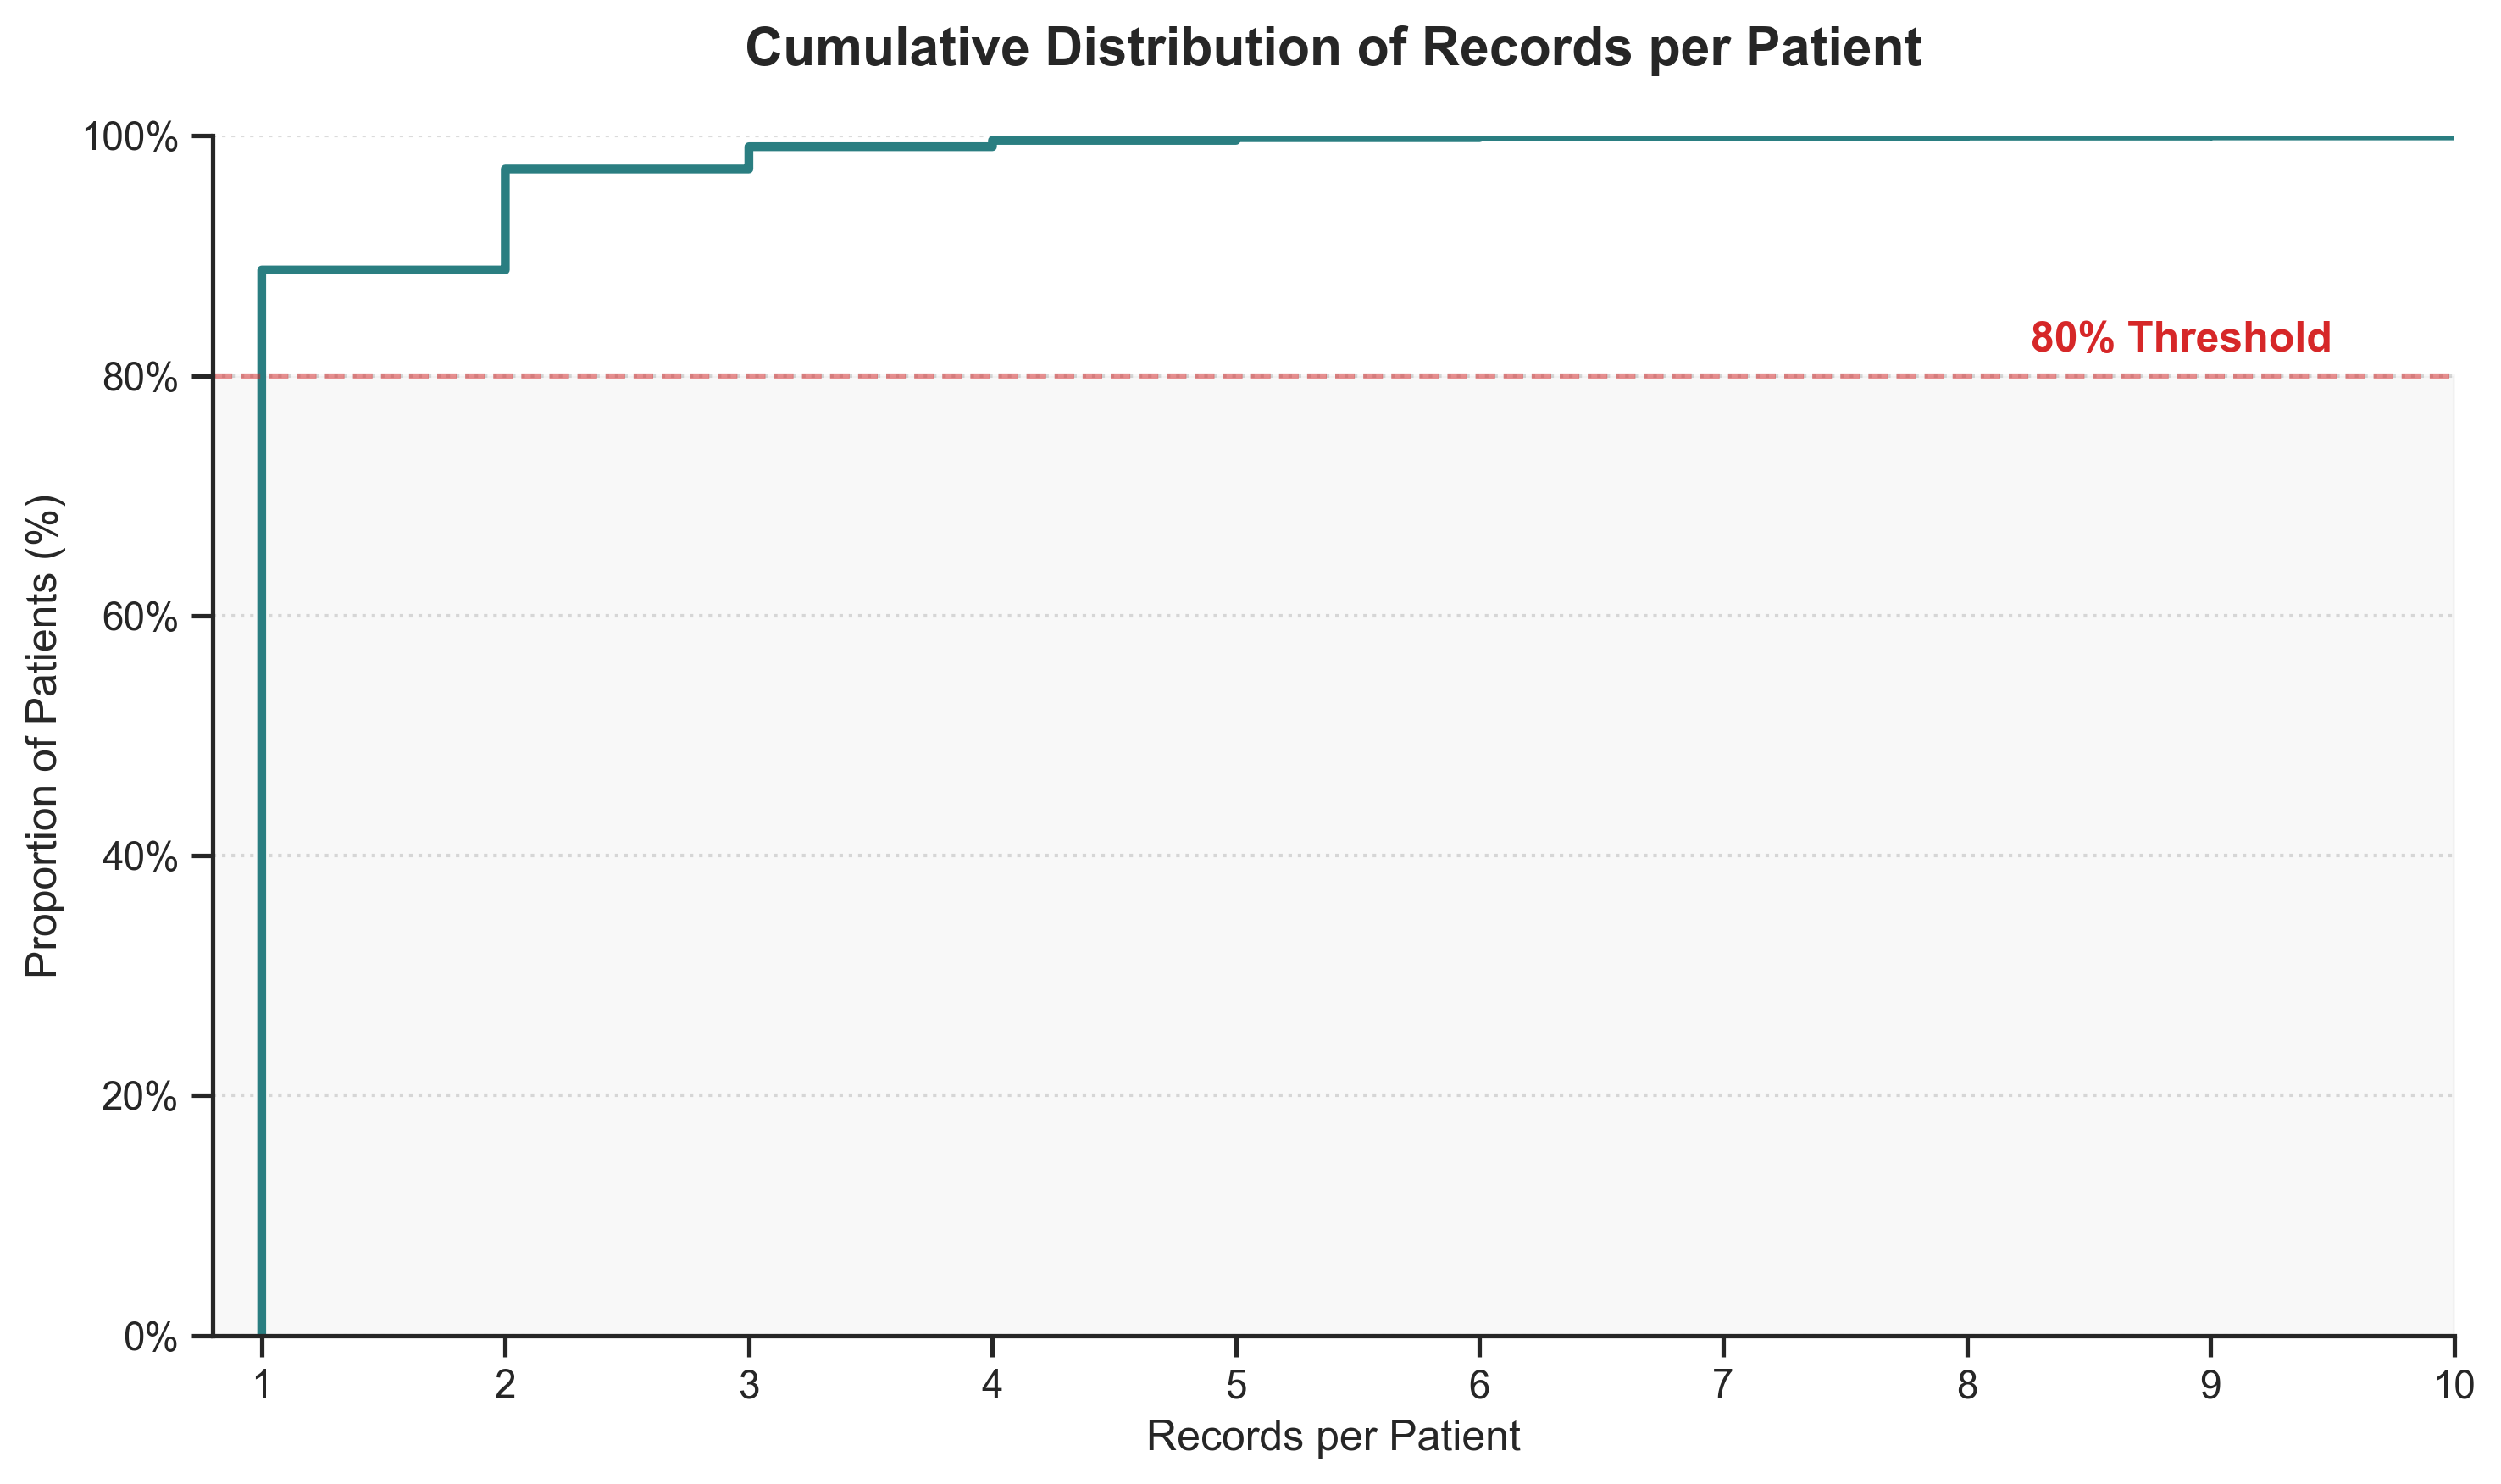

In [121]:
# plot
sns.set_theme(style="ticks") 
plt.figure(figsize=(10, 6))

sns.ecdfplot(
    data=recs_per_patient, 
    color='#2A7E81', 
    linewidth=2.5,
    label='Cumulative Proportion'
)

max_x_view = 10  
plt.xlim(0.8, max_x_view) 
plt.axhline(0.8, color='#D62728', linestyle='--', alpha=0.5)
plt.fill_between([0.8, max_x_view], 0, 0.8, color='gray', alpha=0.05) 
plt.text(max_x_view-0.5, 0.82, '80% Threshold', color='#D62728', fontweight='bold', ha='right')
plt.title('Cumulative Distribution of Records per Patient', fontsize=15, pad=20, weight='bold')
plt.xlabel('Records per Patient', fontsize=12)
plt.ylabel('Proportion of Patients (%)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
plt.xticks(range(1, max_x_view + 1))
sns.despine()
plt.grid(axis='y', linestyle=':', alpha=0.7) 
plt.tight_layout()
plt.show()

Most patients have only one record, making it difficult to detect or correct errors by checking data consistency over time. At the same time, this reduces the risk of data leakage, as it is less likely that the same patient's data will be split across different training and testing sets.

## Age and gender

In [ ]:
# check data and missing rate
print(df[['age', 'height', 'weight']].describe())

missing_rate = df[['age', 'height', 'weight']].isnull().mean() * 100
print("\nMissing rate:")
print(missing_rate)

                age       height       weight
count  21799.000000  6974.000000  9421.000000
mean      62.769301   166.702323    70.995223
std       32.308813    10.867321    15.878803
min        2.000000     6.000000     5.000000
25%       50.000000   160.000000    60.000000
50%       62.000000   166.000000    70.000000
75%       72.000000   174.000000    80.000000
max      300.000000   209.000000   250.000000

Missing rate:
age        0.000000
height    68.007707
weight    56.782421
dtype: float64


Due to privacy policies, the age of individuals older than 89 is set to 300 which need modify. Furthermore, the height and weight data also have unrealistic values that need cleaning. Because so much data is missing, we will not fill in the gaps. Instead, we will set a normal range and remove any values outside of it.

In [114]:
# Data Cleaning
df_c = df.copy()
df_c['age'] = df_c['age'].replace(300, 90)
df_c.loc[(df_c['height'] < 130) | (df_c['height'] > 220), 'height'] = np.nan
df_c.loc[(df_c['weight'] < 30) | (df_c['weight'] > 200), 'weight'] = np.nan
# calculate BMI
df_c['BMI'] = df_c['weight'] / ((df_c['height'] / 100) ** 2)
print("--- Data Cleaning Summary ---")
print(df_c[['age', 'height', 'weight', 'BMI']].describe().loc[['min', 'max', 'mean']])

--- Data Cleaning Summary ---
            age     height      weight        BMI
min    2.000000  135.00000   31.000000  11.753903
max   90.000000  209.00000  200.000000  58.823529
mean  59.946695  166.94363   71.031785  25.217837


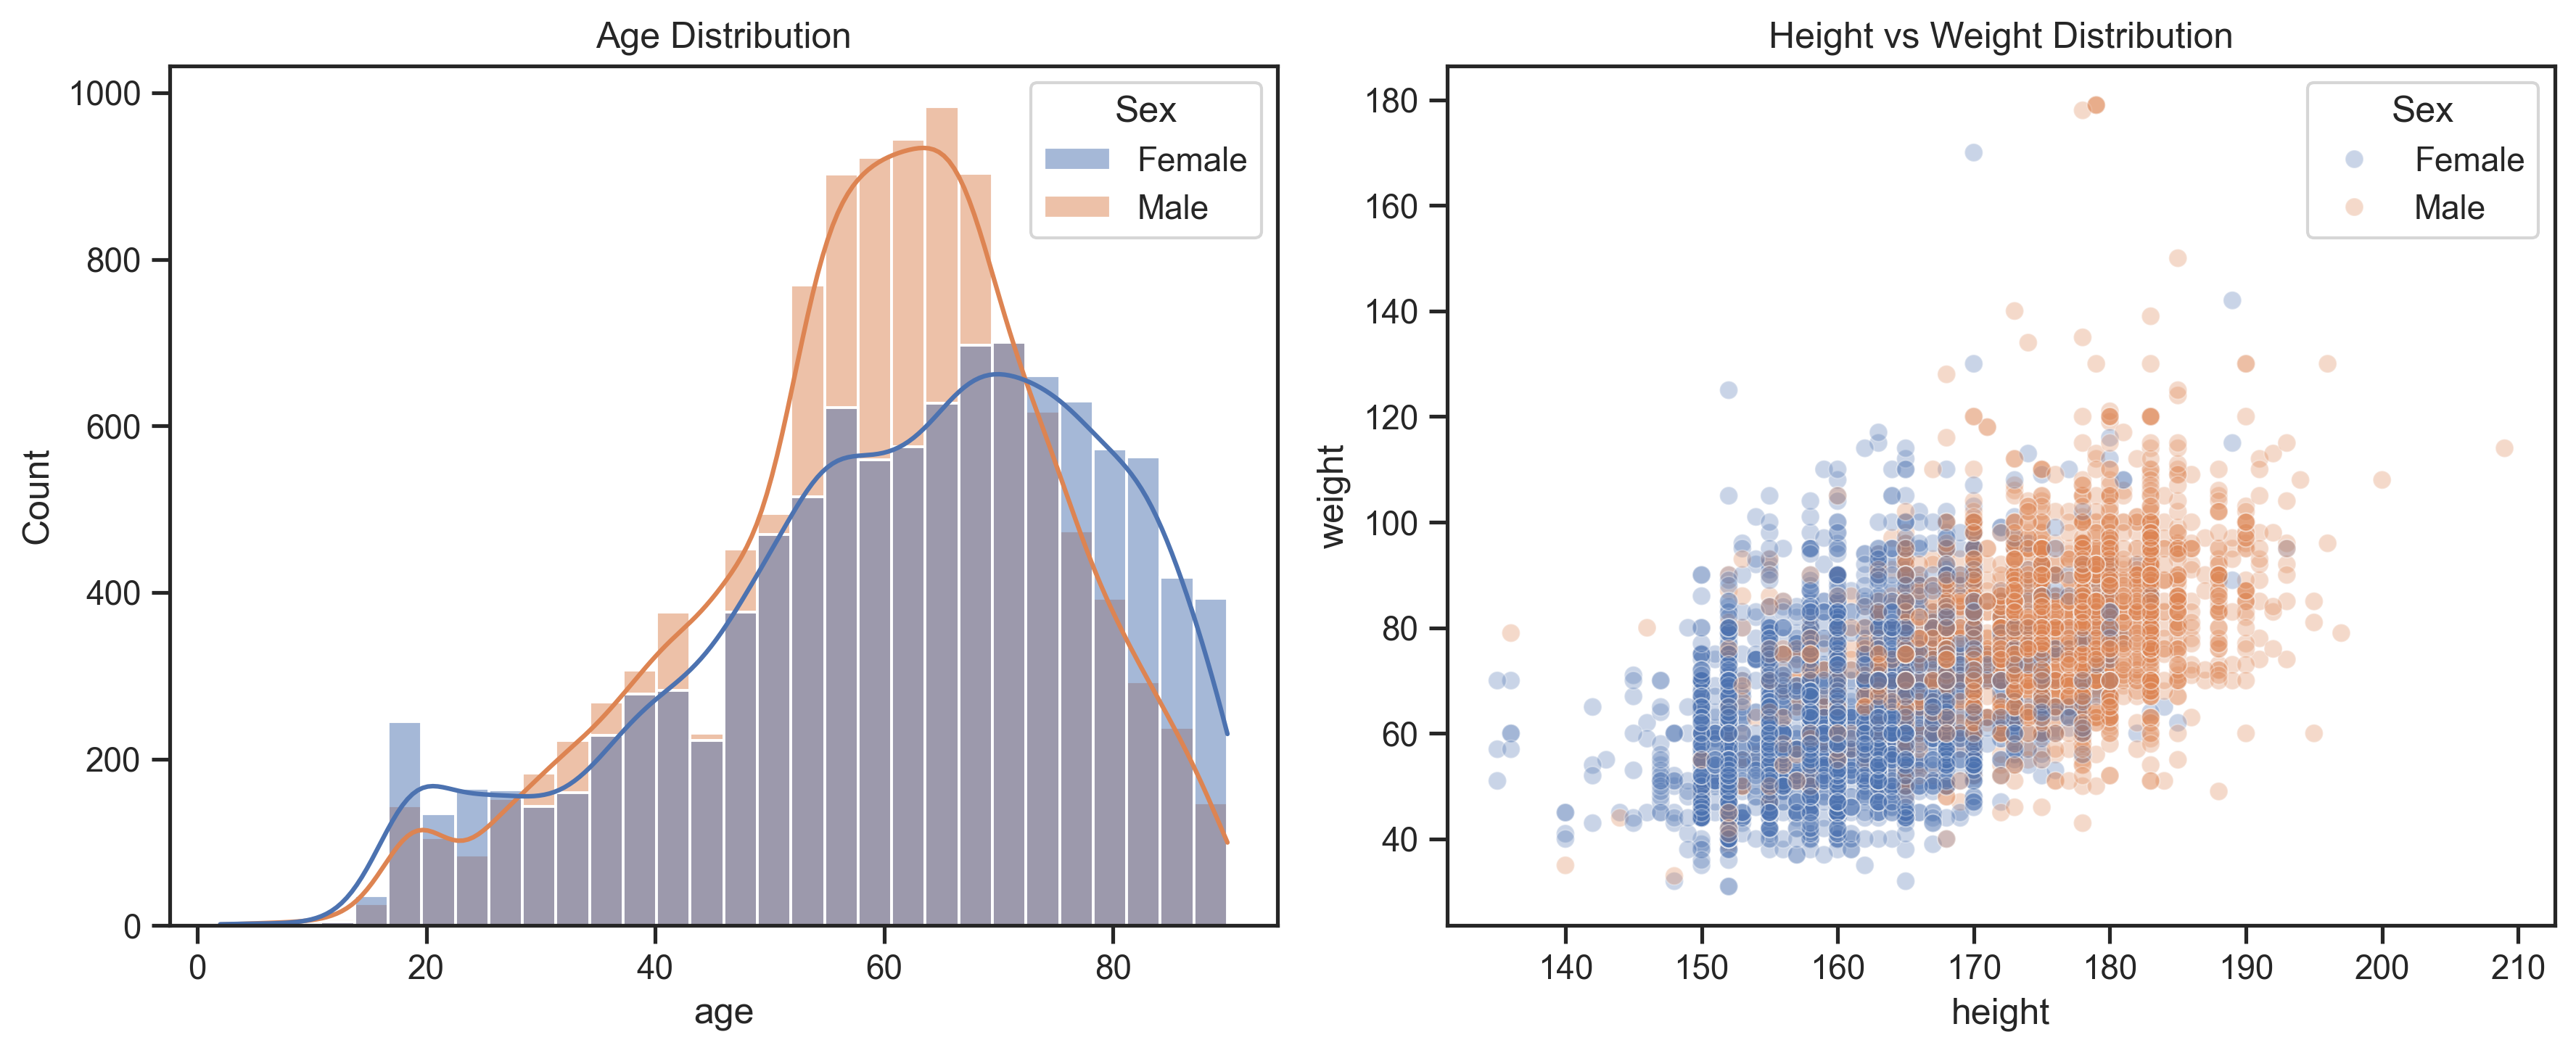

In [115]:
# Plot Age and Sex Distribution
df_c['Sex'] = df_c['sex'].map({0: 'Male', 1: 'Female'})
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_c, x='age', hue='Sex', bins=30, kde=True)
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_c, x='height', y='weight', hue='Sex', alpha=0.3)
plt.title('Height vs Weight Distribution')

plt.tight_layout()
plt.show()

The sample is mainly concentrated in the middle-aged and elderly groups. The distribution curve rises significantly starting from age 40 and peaks between 60 and 70.

Regarding the height and weight distribution, females (blue) are clustered toward the bottom-left, while males (orange) are clustered toward the top-right. There is also a significant overlap between the two groups.


--- Recording Device Distribution ---
       device  count
0  CS100    3   6140
1       CS-12   4048
2  AT-6 C 5.5   3950
3   CS-12   E   2878
4  AT-6     6   2273
5  AT-60    3    966
6  AT-6 C 5.8    824
7      AT-6 C    514
8  AT-6 C 5.0     80
9  AT-6 C 5.3     67

Number of Data Collection Sites: 51


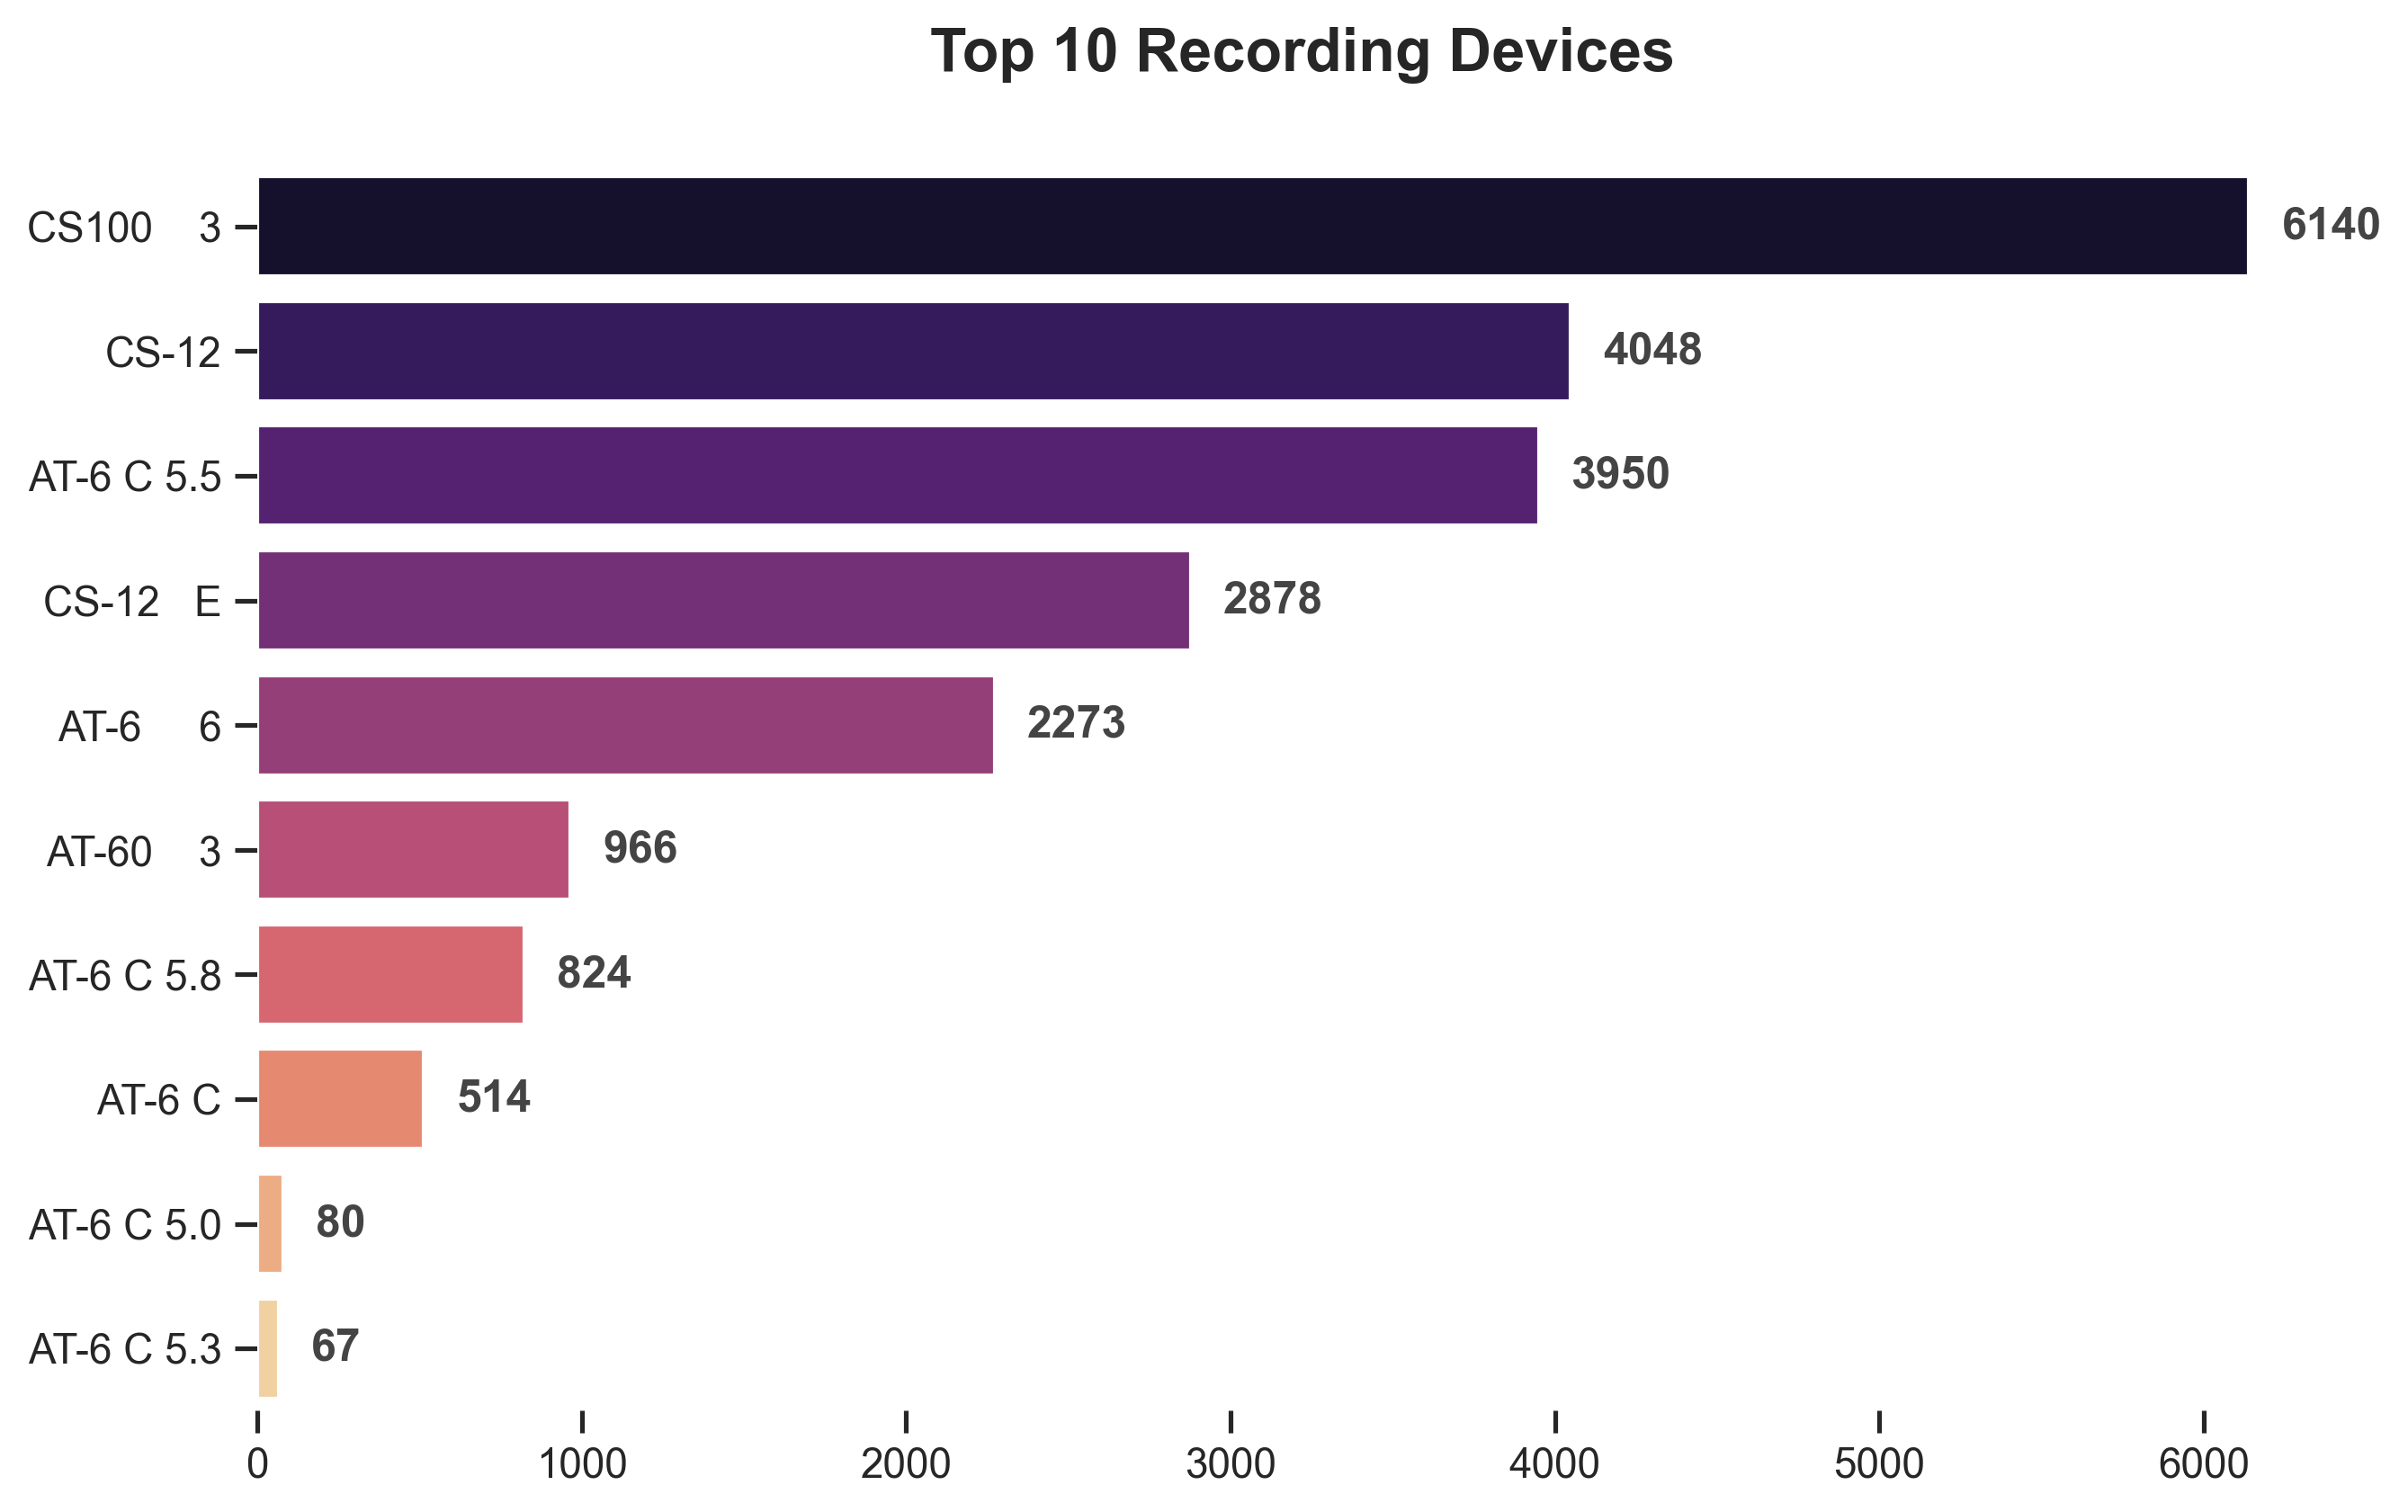

In [99]:
print("\n--- Recording Device Distribution ---")
device_counts = df['device'].value_counts().head(10).reset_index()
device_counts.columns = ['device', 'count']  
print(device_counts)
print(f"\nNumber of Data Collection Sites: {df['site'].nunique()}")

sns.set_theme(style="ticks") 
plt.figure(figsize=(10, 6))
top_devices = device_counts.head(10)
ax = sns.barplot(
    data=top_devices, 
    x='count', y='device', 
    hue='device',
    palette='magma', 
    edgecolor='white', 
    legend=False
)
for i, count in enumerate(top_devices['count']):
    ax.text(count + 100, i, f'{int(count)}', va='center', color='#444444', fontweight='bold')

sns.despine(left=True, bottom=True) 
plt.title('Top 10 Recording Devices', fontsize=16, weight='bold', pad=25)
plt.xlabel('') 
plt.ylabel('')
plt.show()

Device usage is highly concentrated, showing a clear 'head effect'. There is a huge gap between the 5th and 6th rankings. This indicates that the top 5 devices are the mainstream choices in this field.

# 2. Class Distribution and Imbalance Analysis

Class Distribution:
      count  percentage
NORM   3145   46.634045
STTC   1835   27.209371
CD     1513   22.434757
MI     1362   20.195730
HYP    1004   14.887307


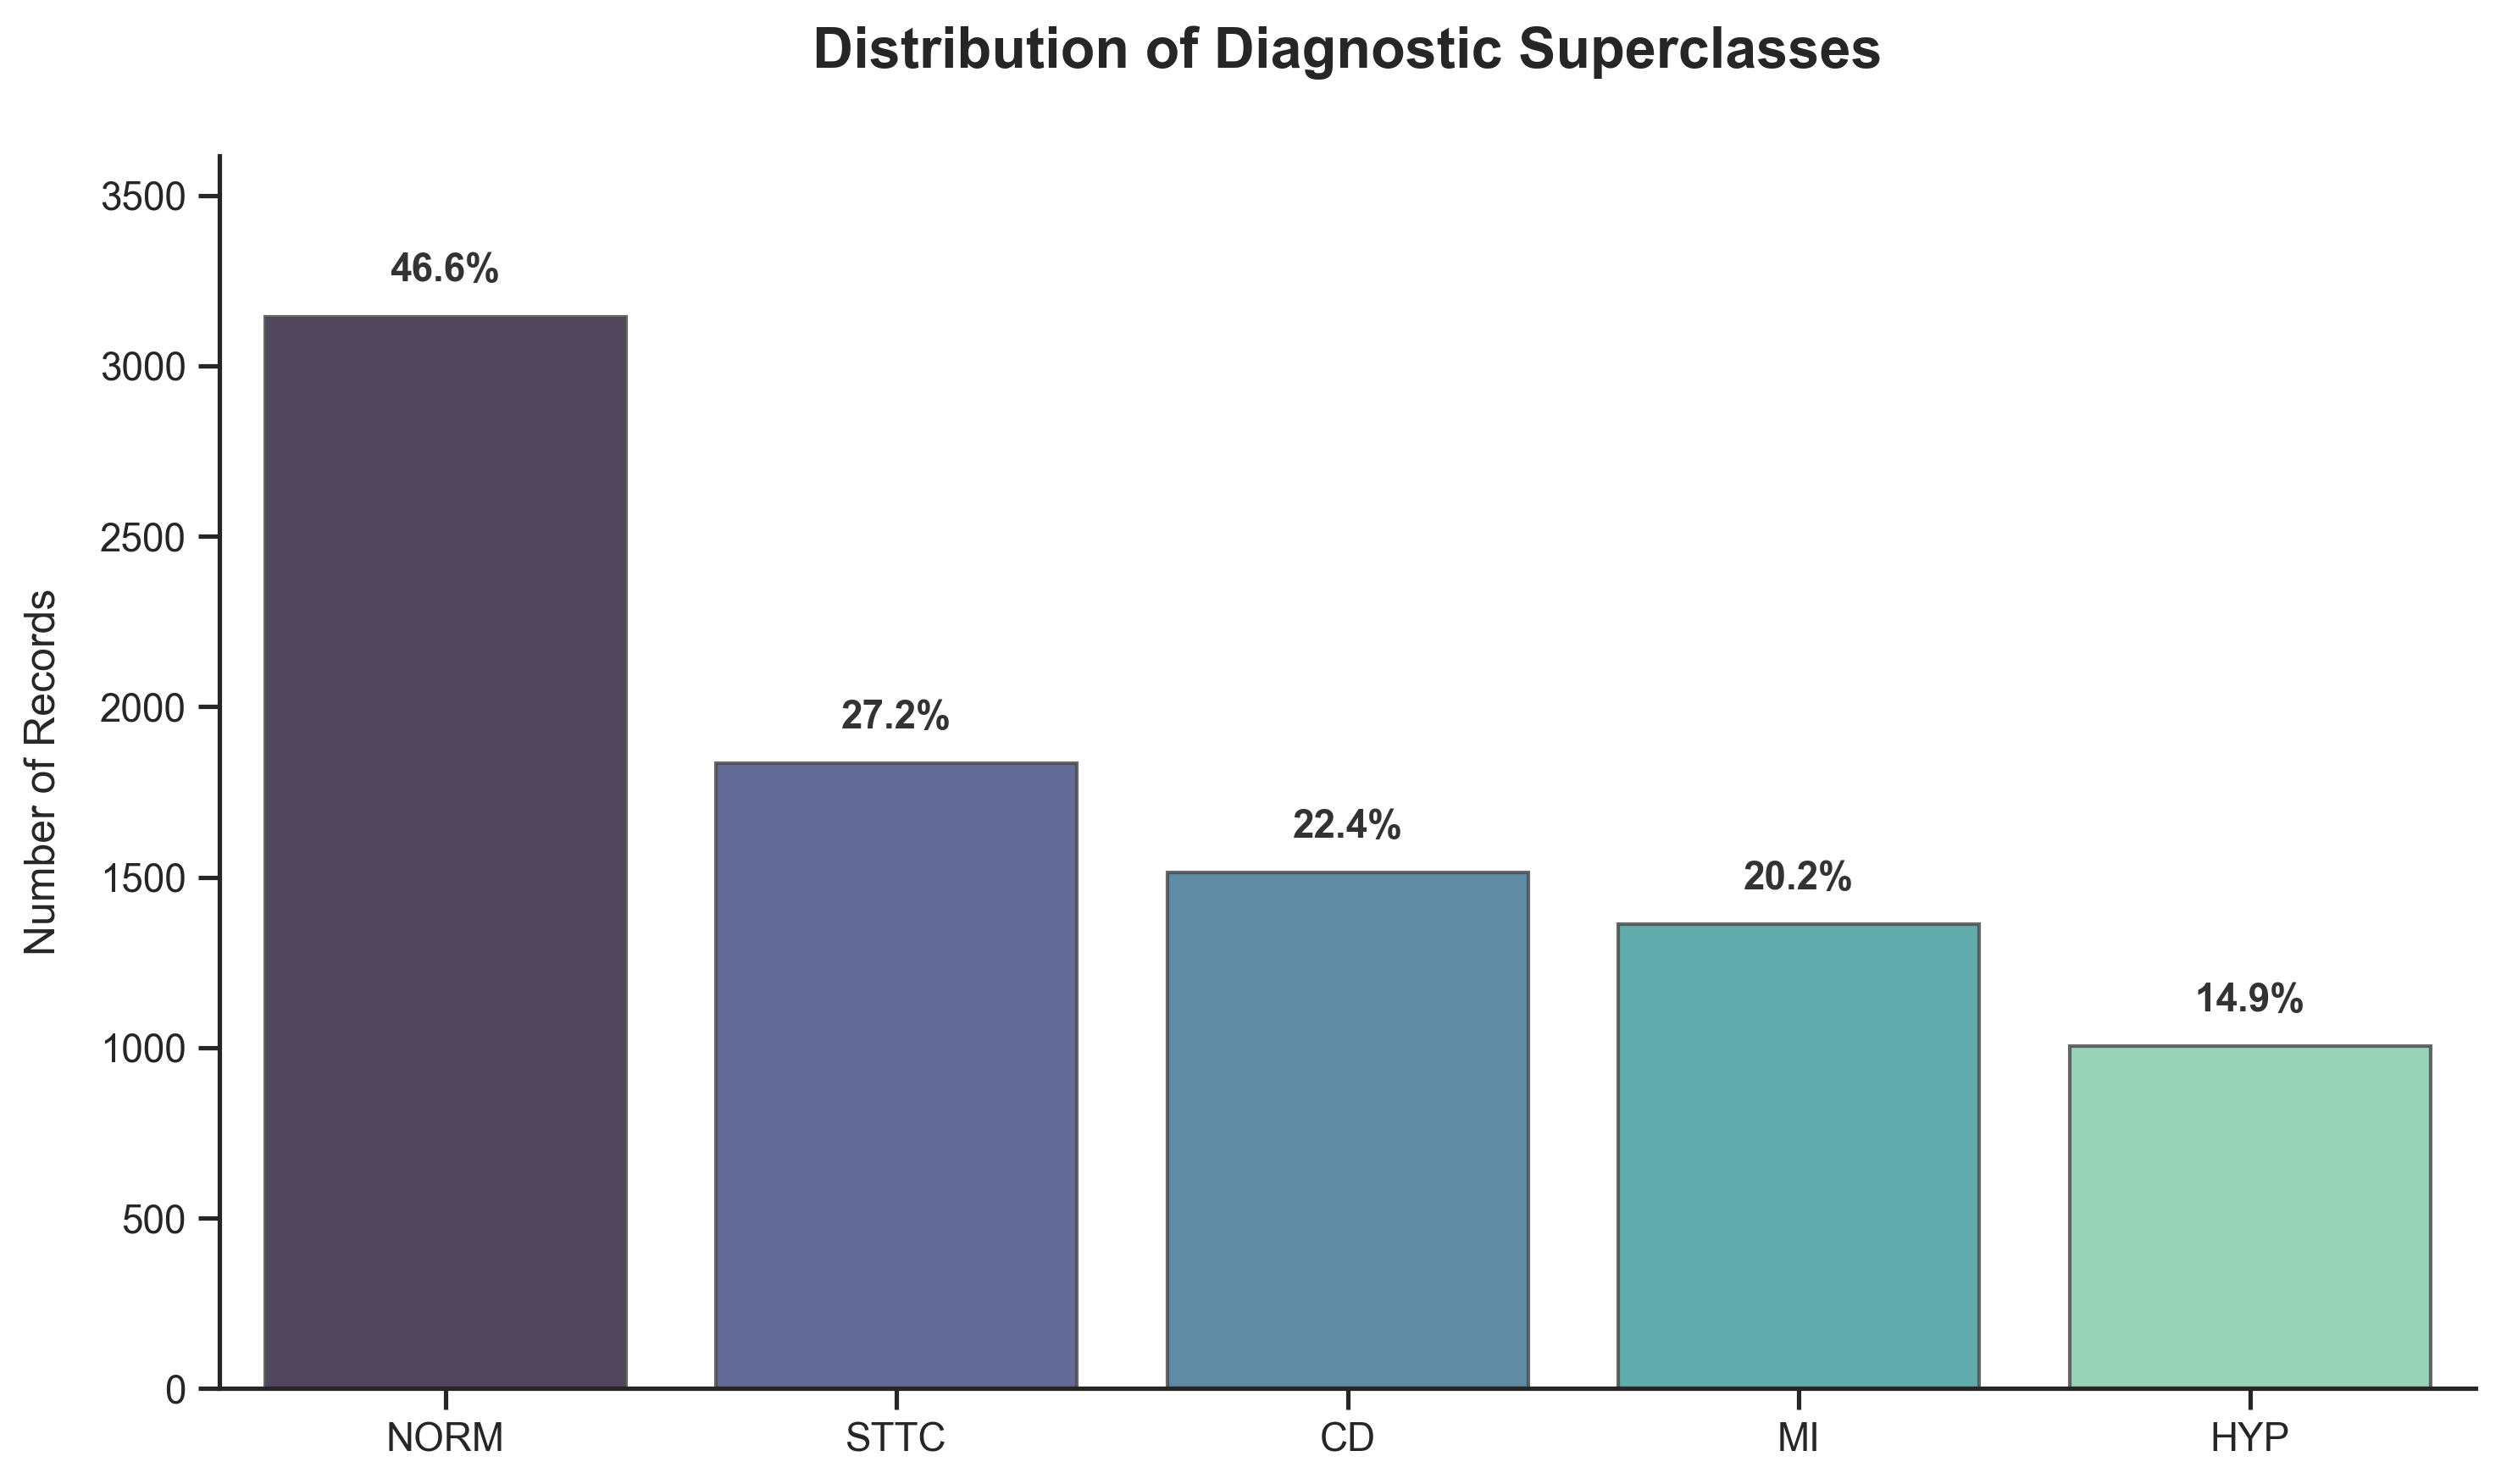

In [105]:
from collections import Counter

# Extract all labels 
all_labels = [label for sublist in df_c['diagnostic_superclass'] for label in sublist]
label_counts = Counter(all_labels)
dist_df = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count']).sort_values('count', ascending=False)
dist_df['percentage'] = (dist_df['count'] / len(df_c)) * 100

print("Class Distribution:")
print(dist_df)

# plot
sns.set_theme(style="ticks") 
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    x=dist_df.index, 
    y=dist_df['count'], 
    hue=dist_df.index,  
    palette='mako',     
    edgecolor='.3',     
    linewidth=1,
    alpha=0.85,
    legend=False       
)

for i, (count, pct) in enumerate(zip(dist_df['count'], dist_df['percentage'])):
    ax.text(
        i, count + 80, f'{pct:.1f}%', 
        ha='center', va='bottom', 
        fontsize=11, fontweight='bold', 
        color='#333333'
    )

plt.title('Distribution of Diagnostic Superclasses', fontsize=16, pad=25, weight='bold')
plt.ylabel('Number of Records', fontsize=12, labelpad=10)
plt.xlabel('') 
sns.despine()
plt.ylim(0, dist_df['count'].max() * 1.15)

plt.tight_layout()
plt.show()

## Co-occurrence Analysis

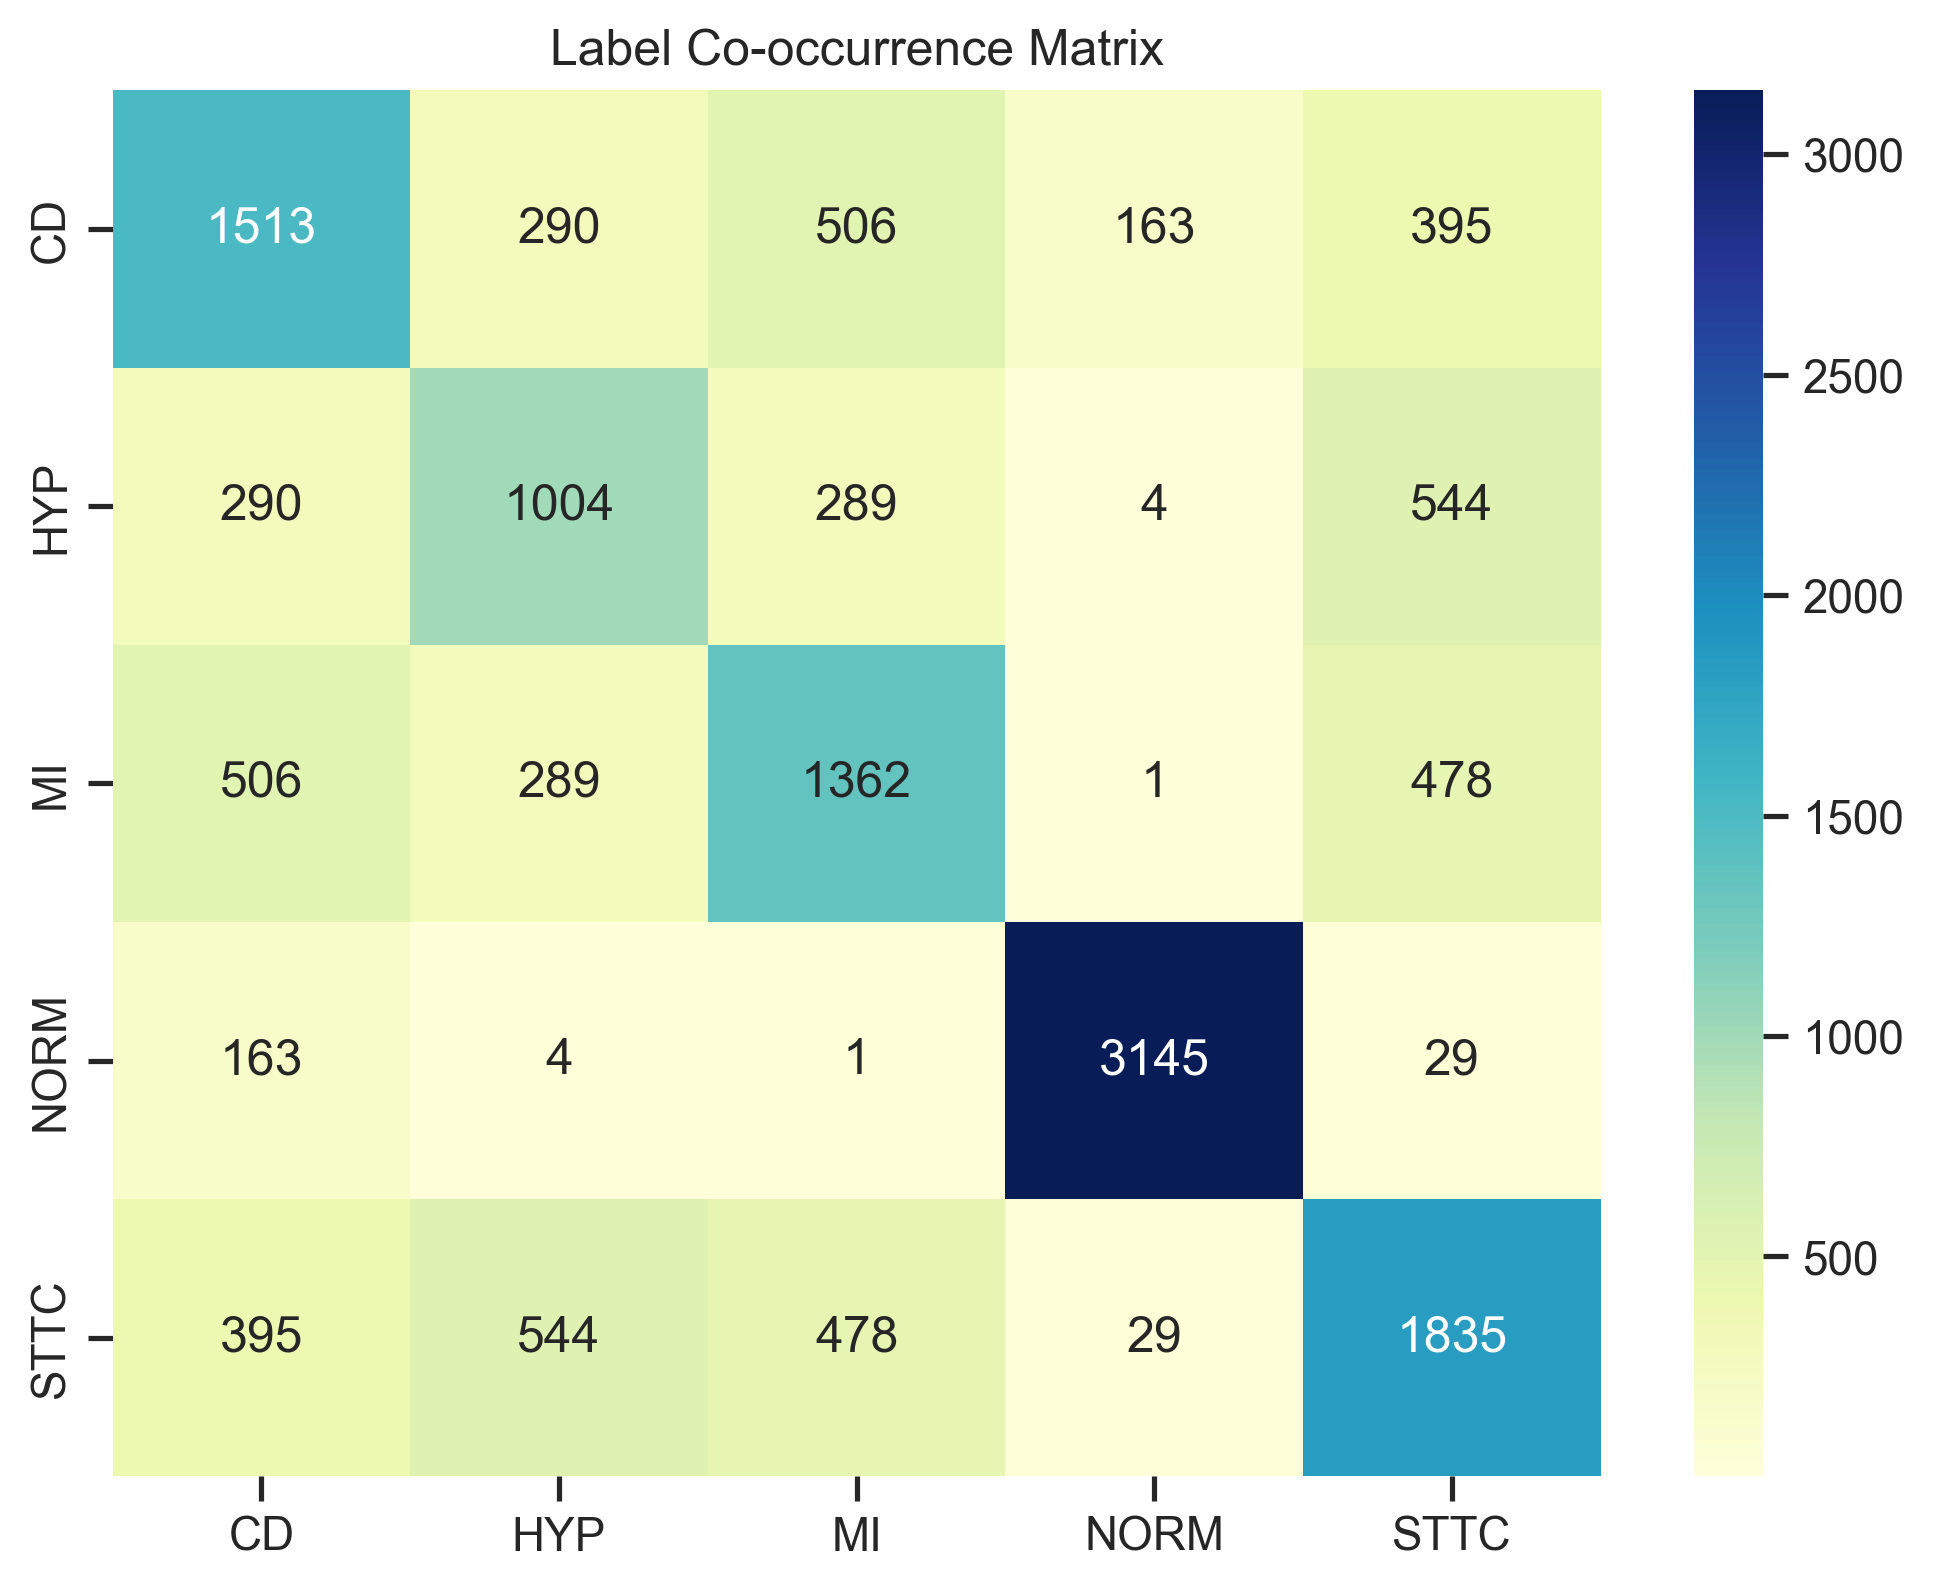

In [107]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
label_matrix = mlb.fit_transform(df_c['diagnostic_superclass'])
label_df = pd.DataFrame(label_matrix, columns=mlb.classes_)
co_occurrence_matrix = label_df.T @ label_df

plt.figure(figsize=(8, 6))
sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Label Co-occurrence Matrix')
plt.show()

--- Imbalance Ratio ---
      count    IR_Lbl
NORM   9514  1.000000
MI     5469  1.739623
STTC   5235  1.817383
CD     4898  1.942425
HYP    2649  3.591544


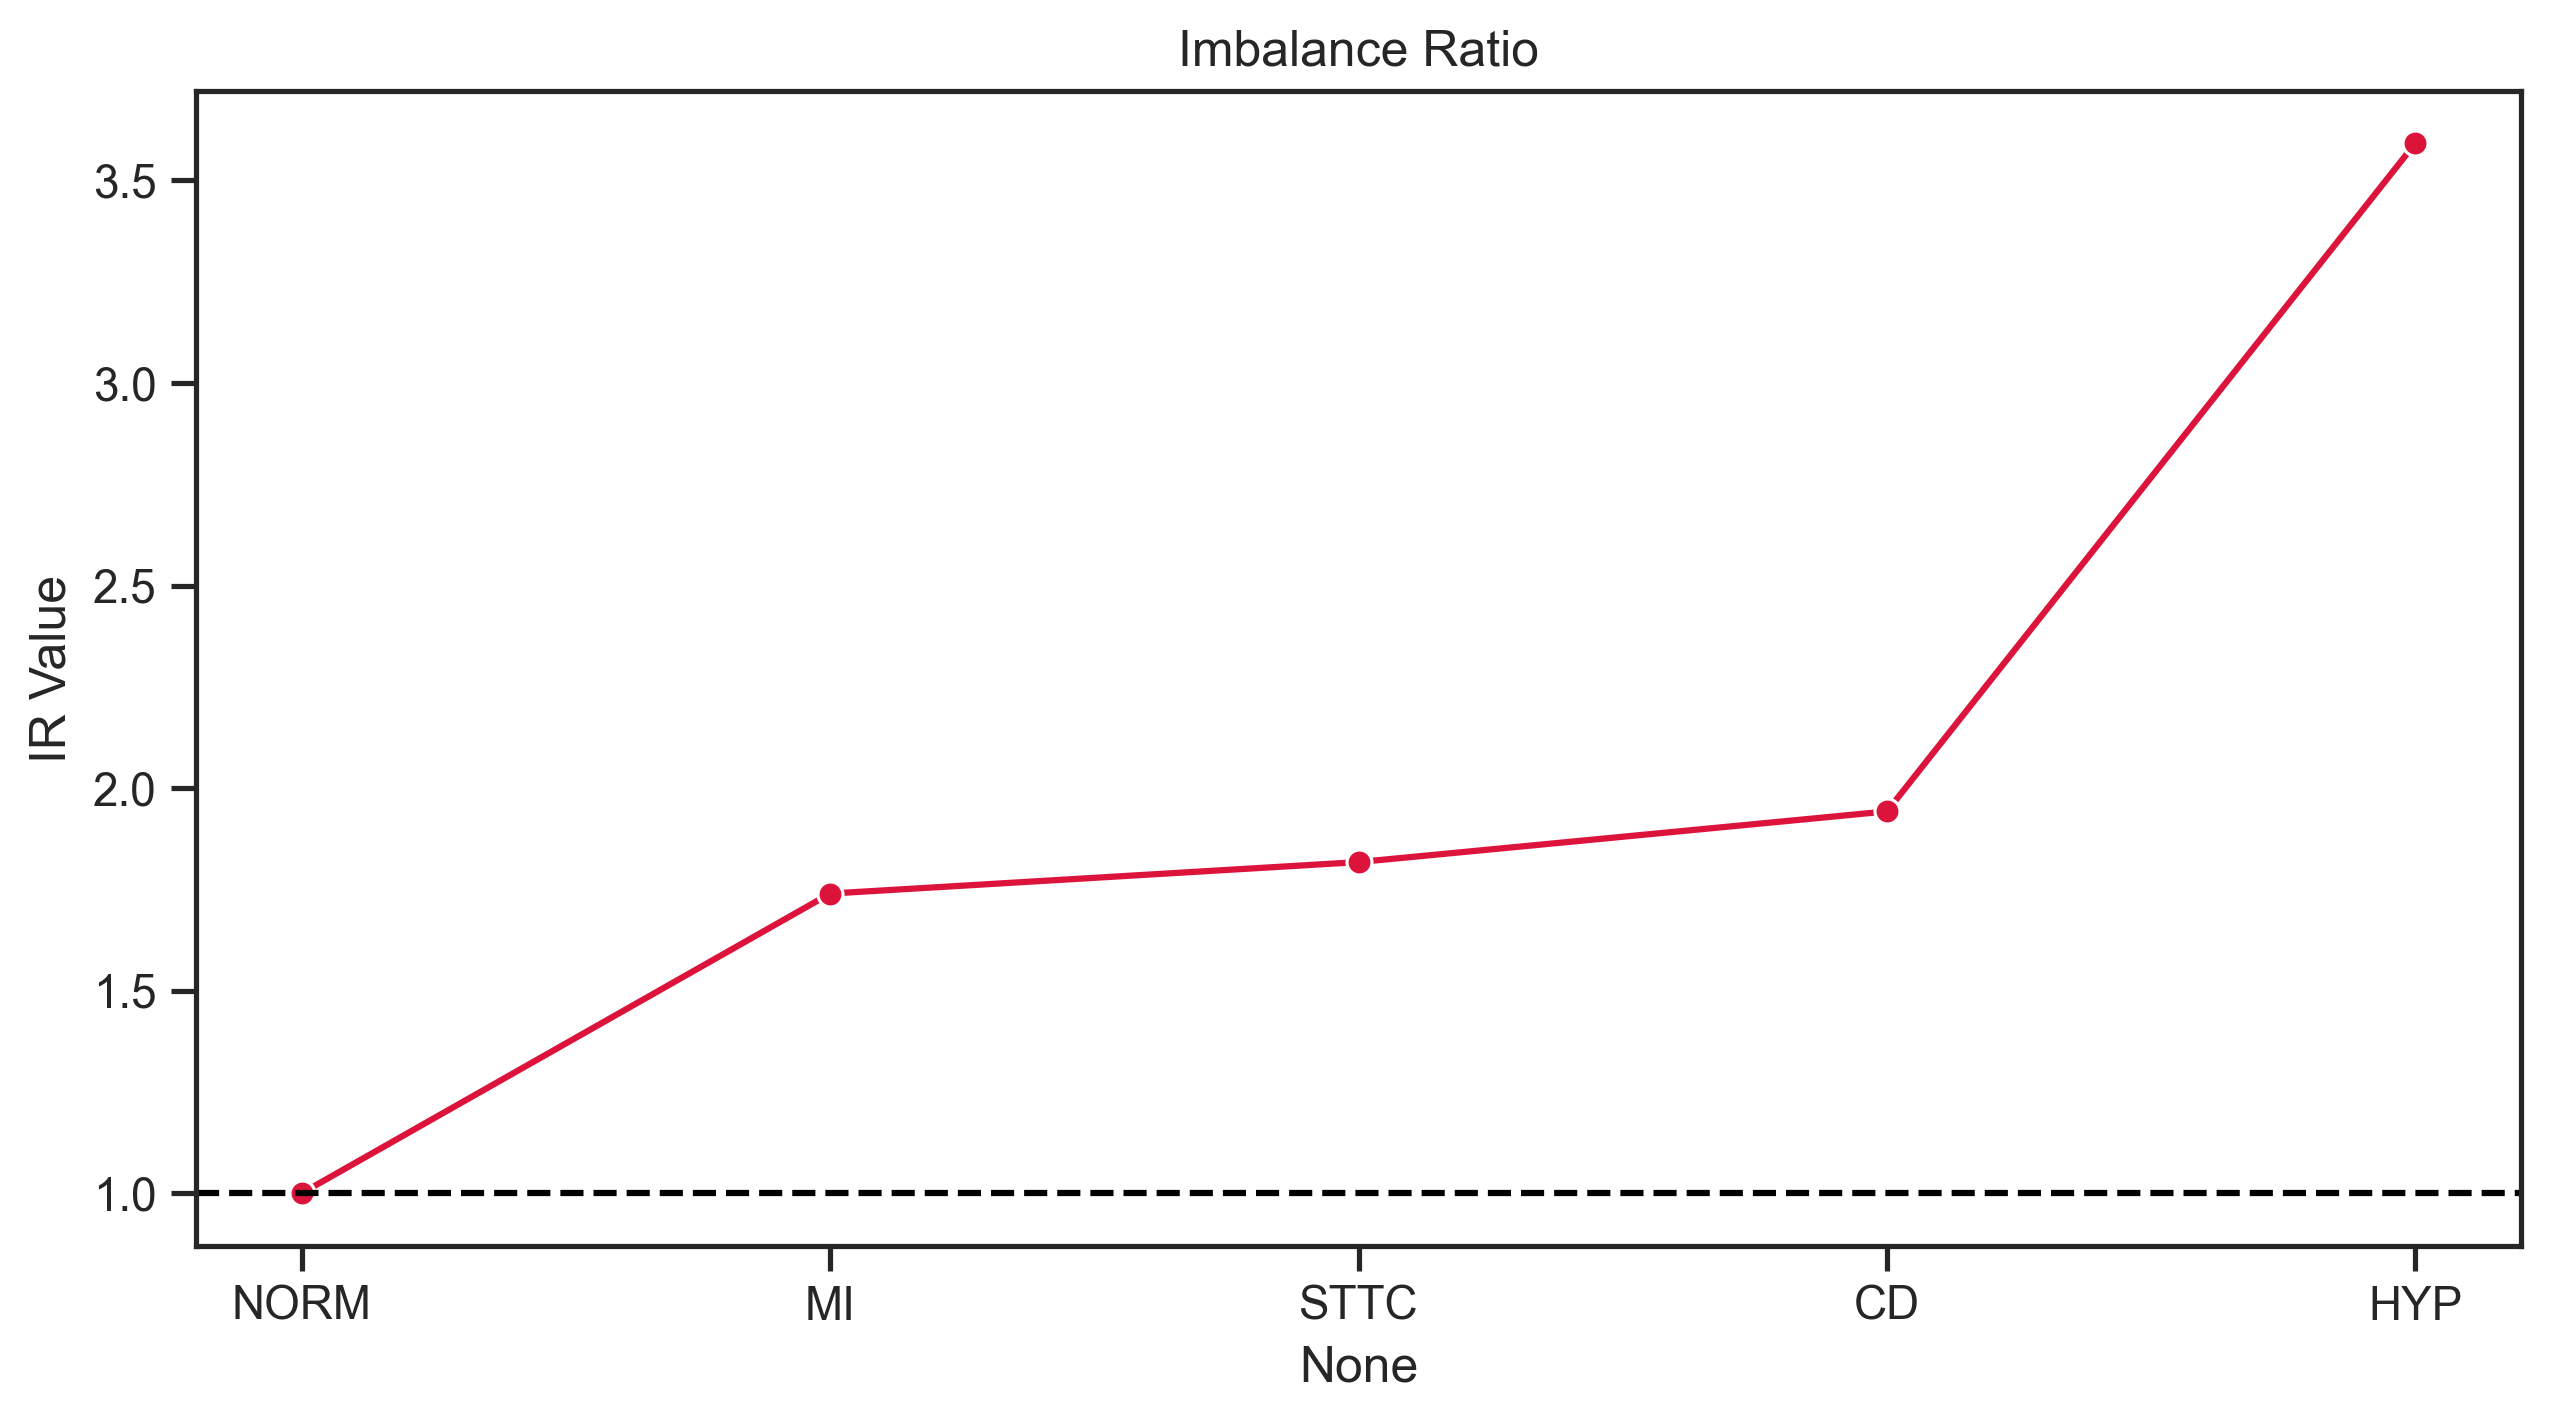

In [122]:
# Imbalance Ratio
max_freq = dist_df['count'].max()
dist_df['IR_Lbl'] = max_freq / dist_df['count']

print("--- Imbalance Ratio ---")
print(dist_df[['count', 'IR_Lbl']].sort_values('IR_Lbl', ascending=True))

# plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=dist_df.index, y=dist_df['IR_Lbl'], marker='o', color='crimson')
plt.axhline(1, color='black', linestyle='--')
plt.title('Imbalance Ratio')
plt.ylabel('IR Value')
plt.show()